### <center>Spline finite difference scheme of the spline collocation method

In [1]:
import numpy as np
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def true_func(x_values):
    x = sp.symbols('x')
    expr = 1 / (x + 1)
    func = sp.lambdify(x, expr, "numpy")
    return func(x_values)


def f_func(x_values):
    x = sp.symbols('x')
    answer_func = 1 / (x + 1)
    expr = sp.diff(answer_func, x, 2) - 2 * answer_func / (x + 1)**2
    func = sp.lambdify(x, expr, "numpy")
    return np.zeros(len(x_values)) if func(x_values) == 0 else func(x_values)
    

def q_func(x_values):
    x = sp.symbols('x')
    expr = -2 / (x + 1)**2
    func = sp.lambdify(x, expr, "numpy")
    return func(x_values)


def tridiagona_matrix_algorithm(A, b):
    n = A.shape[0]
    c = np.zeros(n-1) # subdiagonal elements
    d = np.zeros(n) # main diagonal
    e = np.zeros_like(c) # supradiagonal elements
    
    for i in range(n - 1):
        c[i] = A[i+1, i]
        d[i] = A[i, i]
        e[i] = A[i, i+1]
    d[n-1] = A[n-1, n-1]
    
    alpha = np.zeros(n-1)
    beta = np.zeros_like(alpha)
    
    # Straight direction
    alpha[0] = -e[0] / d[0]
    beta[0] = b[0] / d[0]
    
    for i in range(1, n - 1):
        alpha[i] = -e[i] / (c[i - 1] * alpha[i - 1] + d[i])
        beta[i] = (b[i] - c[i - 1] * beta[i - 1]) / (c[i - 1] * alpha[i - 1] + d[i])
    
    # Reverse direction
    x = np.zeros_like(b)
    x[n - 1] = (b[n - 1] - c[n - 2] * beta[n - 2]) / (c[n - 2] * alpha[n - 2] + d[n - 1])
    
    for i in range(n - 2, -1, -1):
        x[i] = alpha[i] * x[i + 1] + beta[i]

    return x


def cube_spline_collocation(A, b, alpha1, beta1, alpha2, beta2, gamma1, gamma2, f, q):
    h = np.diff(nodes)
    
    A[0, 0] = alpha1 * h[0] - beta1 * (1 - q[0] * h[0]**2 / 3)
    A[0, 1] = beta1 * (1 + q[1] * h[0]**2 / 6)
    b[0] = gamma1 * h[0] + beta1 * h[0]**2 * (2 * f[0] + f[1]) / 6

    for k in range(1, n - 1):
        mu_k = h[k - 1] / (h[k] + h[k - 1])
        A[k, k - 1] = (1 - mu_k) * (1 + h[k - 1]**2 / 6 * q[k - 1])
        A[k, k] = -(1 - h[k - 1] * h[k] / 3 * q[k])
        A[k, k + 1] = mu_k * (1 + h[k]**2 / 6 * q[k + 1])
        b[k] = h[k - 1] * h[k] / 6 * (mu_k * f[k - 1] + 2 * f[k] + (1 - mu_k) * f[k + 1])

    A[n - 1, n - 2] = beta2 * (-1 - h[n - 2]**2 * q[n - 2] / 6)
    A[n - 1, n - 1] = alpha2 * h[n - 2] + beta2 * (1 - h[n - 2]**2 * q[n - 1] / 3)
    b[n - 1] = gamma2 * h[n - 2] - beta2 * h[n - 2]**2 * (f[n - 2] + 2 * f[n - 1]) / 6
    
    return A, b

In [3]:
n = 100
left, right = 0, 1
alpha1, alpha2 = 1, 1
beta1, beta2 = -1, 0
gamma1, gamma2 = 2, 0.5

In [4]:
nodes = np.linspace(left, right, n)
q = q_func(nodes)
f = f_func(nodes)
A = np.zeros((n, n))
b = np.zeros(n)

In [5]:
A, b = cube_spline_collocation(
    A = A,
    b = b,
    alpha1 = alpha1,
    beta1 = beta1,
    alpha2 = alpha2,
    beta2 = beta2,
    gamma1 = gamma1,
    gamma2 = gamma2,
    f = f,
    q = q
)

In [6]:
true_values = true_func(nodes)
result_values = tridiagona_matrix_algorithm(A, b)

nodes_error = np.abs(result_values - true_values)

print(f"Max_error: {np.max(nodes_error)}")

Max_error: 1.4777163920731695e-05


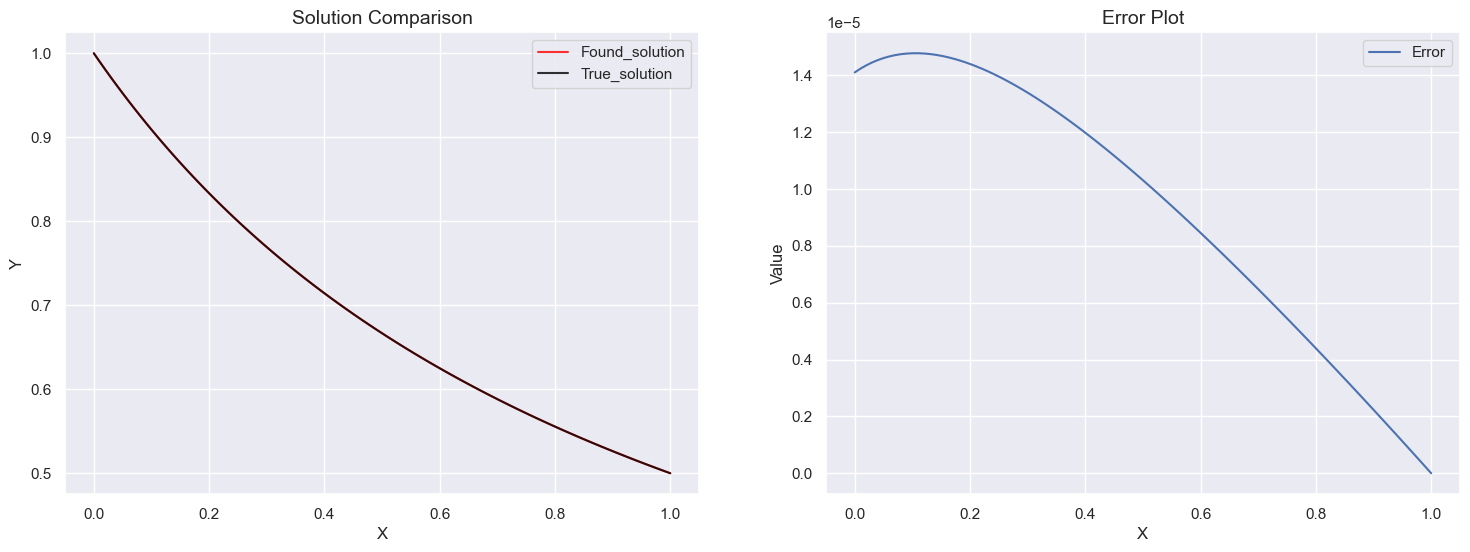

In [7]:
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(ax=axs[0], y=result_values, x=nodes, label="Found_solution", alpha=0.8, c="red")
sns.lineplot(ax=axs[0], y=true_values, x=nodes, label="True_solution", alpha=0.8, c="black")
axs[0].set_xlabel("X", fontsize=12)
axs[0].set_ylabel("Y", fontsize=12)
axs[0].set_title("Solution Comparison", fontsize=14)
axs[0].legend()

sns.lineplot(ax=axs[1], y=nodes_error, x=nodes, label="Error")
axs[1].set_xlabel("X", fontsize=12)
axs[1].set_ylabel("Value", fontsize=12)
axs[1].set_title("Error Plot", fontsize=14)
axs[1].grid(True)

plt.show()